# Classification Models

## Table of contents:
* [Maximum Likelihood logistic regression](#maxlike)
* [Bayesian logistic regression](#bayesian)
* [Non-linear logistic regression](#non-linear)
* [Dual logistic regression](#dual)
* [Relevance vector classification](#relevant-vector)
* [Incremental fitting and boosting](#boosting)
* [Classification trees](#trees)
* [Multi-class logistic regression](#multiclass)
* [Random trees, forests, and ferns](#forest)
* [Multi-class logistic regression](#multiclass)

# Bayesian logistic regression

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spsp
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [89]:
def generate_data_set_dim1_linear(ns):
    """
    this function generates a 1d data set of two classes which are linearly separated.
    
    Arguments:
        ns: number of samples
    
    Output:
        ds1   : data on the negative side (2, ns). ds1[1] = 0 is the label.
        ds2   : data on the positive side (2, ns). ds2[1] = 1 is the label.
        data  : data combined ds1 and ds2 and shuffled. (1, ns)
        label : label combined ds1 and ds2 and shuffled. (1, ns)
        datab : data combined ds1 and ds2 and shuffled. data1[0] = 1 for bias. (2, ns)
    """
    ns_neg = int(0.5 * ns)
    ns_pos = ns - ns_neg
    nfar_neg = int(0.7 * ns_neg)
    nbdr_neg = ns_neg - nfar_neg
    nfar_pos = int(0.7 * ns_pos)
    nbdr_pos = ns_pos - nfar_pos
    
    far_neg = 8 * (np.random.rand(nfar_neg) - .5) - 5
    bdr_neg = np.random.standard_t(4, size=nbdr_neg) - 0.5
    ds1 = np.hstack((far_neg, bdr_neg))
    ds1 = np.vstack((ds1, np.zeros(ns_neg)))
    
    far_pos = 8 * (np.random.rand(nfar_pos) - .5) + 5
    bdr_pos = np.random.standard_t(4, size=nbdr_pos) + 0.5
    ds2 = np.hstack((far_pos, bdr_pos))
    ds2 = np.vstack((ds2, np.ones(ns_pos)))
    
    ds = np.hstack((ds1, ds2))
    np.random.shuffle(ds.T)
    data = ds[0]
    label = ds[1][np.newaxis, :]
    datab = np.vstack((np.ones(ns), data))
    
    #plt.rcParams['figure.figsize'] = (5.0, 3.0)
    #plt.plot(ds1[0], ds1[1], 'r.', markersize=3)
    #plt.plot(ds2[0], ds2[1], 'b.', markersize=3)
    return ds1, ds2, data, label, datab


def generate_data_set_dim2_linear(ns):
    """
    this function generates a 2d data set of two classes which are linearly separated.
    
    Arguments:
        ns: number of samples
    
    Output:
        ds1: data on the negative side (3, ns). ds1[1] = 0 is the label.
        ds2: data on the positive side (3, ns). ds2[1] = 0 is the label.
        data  : data combined ds1 and ds2 and shuffled. (2, ns)
        label : label combined ds1 and ds2 and shuffled. (2, ns)
        datab : data combined ds1 and ds2 and shuffled. datab[0] = 1 for bias. (3, ns)
    """
    ns_neg = int(0.5 * ns)
    ns_pos = ns - ns_neg
    nfar_neg = int(0.7 * ns_neg)
    nbdr_neg = ns_neg - nfar_neg
    nfar_pos = int(0.7 * ns_pos)
    nbdr_pos = ns_pos - nfar_pos
    
    far_neg = 8 * (np.random.rand(nfar_neg) - .5) - 5
    bdr_neg = np.random.standard_t(4, size=nbdr_neg) - 0.5
    ds1x = np.hstack((far_neg, bdr_neg))
    ds1y = 10 * (np.random.rand(ns_neg) - .5)
    ds1 = np.vstack((ds1x, ds1y))
    
    far_pos = 8 * (np.random.rand(nfar_pos) - .5) + 5
    bdr_pos = np.random.standard_t(4, size=nbdr_pos) + 0.5
    ds2x = np.hstack((far_pos, bdr_pos))
    ds2y = 10 * (np.random.rand(ns_pos) - .5)
    ds2 = np.vstack((ds2x, ds2y))
    
    ang = np.pi * np.random.rand() 
    c, s = np.cos(ang), np.sin(ang)
    rot = np.array([[c, s], [-s, c]])
    
    ds1 = np.dot(rot, ds1)
    ds2 = np.dot(rot, ds2)
    
    ds1 = np.vstack((ds1, np.zeros(ns_neg)))
    ds2 = np.vstack((ds2, np.ones(ns_pos)))
    ds = np.hstack((ds1, ds2))
    np.random.shuffle(ds.T)
    
    data = ds[:2]
    label = ds[2][np.newaxis, :]
    datab = np.vstack((np.ones(ns), data))
    
    #plt.rcParams['figure.figsize'] = (5.0, 5.0)
    #plt.plot(ds1[0], ds1[1], 'r.', markersize=3)
    #plt.plot(ds2[0], ds2[1], 'b.', markersize=3)
    return ds1, ds2, data, label, datab, ang


def cost_function(datab, label, phi):
    """
    this function computes logistic cost function
    
    Arguments:
        datab:  (D, ns)  D contains bias as well.
        label:  (1, ns)
        phi  :  (1, D)
    
    Output:
        L:     scalar. cost function.
    """
    sig = sigmoid(datab, phi)
    wlogsig1 = np.dot(label, np.log(sig))
    wlogsig2 = np.dot(1 - label, np.log(1 - sig))
    L = wlogsig1 + wlogsig2
    return L


def dL_dphi(datab, label, phi, sgp):
    """
    this function computes logistic cost function
    
    Arguments:
        datab:   (D, ns)  D contains bias as well.
        label:   (1, ns)
        phi  :   (1, D)
    
    Output:
        dLdphi:  (D, 1). derivative of cost function with respect to \vec{phi}.
    """
    # sig = (ns, 1) 
    # dlt = (ns, 1)
    # dLdphi = (D, 1)
    sig = sigmoid(datab, phi)
    dlt = sig - label.T 
    dLdphi = -np.dot(datab, dlt) - phi.T / (sgp ** 2)
    return dLdphi


def dL_hess(datab, phi, sgp):
    """
    this function computes logistic cost function
    
    Arguments:
        datab:   (D, ns)  D contains bias as well.
        label:   (1, ns)
        phi  :   (1, D)
    
    Output:
        dLhess:  (D, D).  Hessian of cost function with respect to \vec{phi}.
    """
    sig = sigmoid(datab, phi)
    sig1sig = sig * (1 - sig)
    sig1sigx = sig1sig * datab.T
    dLhess = -np.dot(datab, sig1sigx) - 1 / (sgp ** 2)
    return dLhess

    
def sigmoid(datab, phi):
    """
    this function computes sigmoid function
    
    Arguments:
        datab:  (D, ns).  D contains bias as well.
        phi  :  (1, D)
    
    Output:
        sig  :  (ns, 1)
    """
    phix = np.dot(phi, datab)
    denom = 1 + np.exp(-phix) 
    sig = 1 / denom
    return sig.T


def newton_method_update(datab, label, phi, alpha, sgp):
    """
    this function computes sigmoid function
    
    Arguments:
        datab:   (D, ns)  D contains bias as well.
        label:   (1, ns)
        phi  :   (1, D)
        alpha:   scalar
    
    Output:
        sig  :  (ns, 1)
    """
    dLdphi = dL_dphi(datab, label, phi, sgp)
    hess = dL_hess(datab, phi, sgp)
    hessinv = np.linalg.inv(hess)
    phi -= alpha * np.dot(hessinv, dLdphi).T
    return phi
    
    
def newton_method(datab, label, phi, alpha, sgp):
    """
    this function computes sigmoid function
    
    Arguments:
        datab:   (D, ns)  D contains bias as well.
        label:   (1, ns)
        phi  :   (1, D)
        alpha:   scalar
    
    Output:
        sig  :  (ns, 1)
    """
    import copy
    dlt = 1
    step = 0
    D = phi.shape[1]
    phis = np.zeros((10000, D))
    phis[step, :] = phi
    while dlt > 0.001:
        step += 1
        temp = copy.deepcopy(phi)
        phi = newton_method_update(datab, label, phi, alpha, sgp)
        phis[step, :] = phi
        dlt = np.max(np.abs(temp - phi)/temp)
    strng = '{:d} steps done: \n'.format(step + 1)
    for i in range(D):
        strng += '{:1.4f}, '.format(phi.squeeze()[i])
    print(strng)
    phis = phis[:(step + 1), :]
    return phi, phis


def maximum_a_posterior(datab, label, phi, alpha, sgp):
    """
    this function computes sigmoid function
    
    Arguments:
        datab:   (D, ns)  D contains bias as well.
        label:   (1, ns)
        phi  :   (1, D)
        alpha:   scalar
        sgp  :   scalar. prior sigma
    
    Output:
        mu_map   :  (D, 1). MAP phi.
        sgms_map :  (D, D). MAP sigma squared.
    """
    phi, _ = newton_method(datab, label, phi, alpha, sgp)
    mu_map = phi
    hess = dL_hess(datab, phi, sgp)
    sgms_map = -np.linalg.inv(hess)
    return mu_map, sgms_map


def bayesian_inference(mu, sgms, nres):
    """
    Arguments:
        mu:    (1, D). MAP phi
        sgma:  (D, D). MAP sigma squared
        nres:  resolution of the curve/image
        
    Output:
        plot.
    """
    D = mu.shape[1]
    if D == 3:
        nn = nres**2
        xres = np.linspace(-10, 10, nres)
        yres = np.linspace(-10, 10, nres)
        yg, xg = np.meshgrid(yres, xres)
        x_flat = xg.reshape(1, nn)
        y_flat = yg.reshape(1, nn)
        x1_flat = np.vstack((np.ones(nn), x_flat))
        xy1_flat = np.vstack((x1_flat, y_flat))
        mus  = np.dot(phi, xy1_flat)
        sgmss = (np.dot(sgms, xy1_flat) * xy1_flat).sum(axis=0)
        arg = np.sqrt(1 + np.pi * sgmss / 8)
        denom = 1 + np.exp(-mus / arg)
        lmbd = 1 / denom
        lmbd = lmbd.reshape((nres, nres)).T
        lmbd = np.fliplr(lmbd)
        return lmbd
    elif D == 2:
        xres = np.linspace(-10, 10, nres)
        x1_flat = np.vstack((np.ones(nres), xres))
        mus  = np.dot(phi, x1_flat)
        sgmss = (np.dot(sgms, x1_flat) * x1_flat).sum(axis=0)
        arg = np.sqrt(1 + np.pi * sgmss / 8)
        denom = 1 + np.exp(-mus / arg)
        lmbd = 1 / denom
        return lmbd
    else:
        print('We don''t cover such case here')




191 steps done: 
-0.2562, 1.2394, 


(-0.1, 1.1)

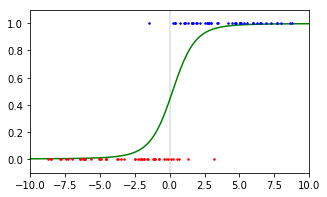

In [87]:
ns = 100
sgp = 5.
alpha = 0.01
nres = 201
phi = np.ones((1, 2))
ds1, ds2, data, label, datab = generate_data_set_dim1_linear(ns)
mu_map, sgms_map = maximum_a_posterior(datab, label, phi, alpha, sgp)
lmbd = bayesian_inference(mu_map, sgms_map, nres)

plt.rcParams['figure.figsize'] = (5.0, 3.0)
plt.plot([0., 0.], [-1., 2.], '-', markersize=3, color=(0., 0., 0.), lw = 0.2)
xr = np.linspace(-10., 10.,nres)
plt.plot(xr, lmbd.squeeze(), 'g-')
plt.plot(ds1[0], ds1[1], 'r.', markersize=3)
plt.plot(ds2[0], ds2[1], 'b.', markersize=3)
plt.xlim(-10., 10.)
plt.ylim(-0.1, 1.1)


613 steps done: 
0.5776, 1.2154, -1.7133, 


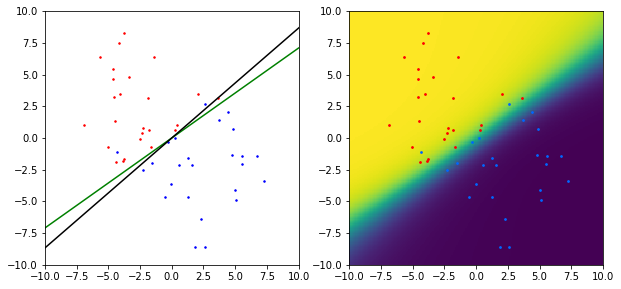

In [91]:
ns = 50
sgp = 5.
alpha = 0.01
phi = np.ones((1, 3))
ds1, ds2, data, label, datab, ang = generate_data_set_dim2_linear(ns)
mu_map, sgms_map = maxapost(datab, label, phi, alpha, sgp)

plt.rcParams['figure.figsize'] = (10.0, 5.0)
ax = plt.subplot(1,2,1)
xr = np.array([-10., 10.])
plt.plot(ds1[0], ds1[1], 'r.', markersize=3)
plt.plot(ds2[0], ds2[1], 'b.', markersize=3)
plt.plot(xr, -phi[0][1]/phi[0][2] * xr, 'g-')
plt.xlim(-10., 10.)
plt.ylim(-10., 10.)
ax.set_aspect(1)

tht = ang + 0.5 * np.pi
c, s = np.cos(tht), np.sin(tht)
rot = np.array([[c, s], [-s, c]])
yr1 = np.dot(rot, np.array([20., 0.]))
yr2 = np.dot(rot, np.array([-20., 0.]))
plt.plot([yr1[0], yr2[0]], [yr1[1], yr2[1]], '-', color=(0.0, 0.0, 0.0))

plt.subplot(1,2,2)
lmbd = bayesian_inference(mu_map, sgms_map, nres)
plt.imshow(lmbd, extent=[-10, 10, -10, 10])
plt.scatter(ds1[0], ds1[1], s=3, c=(1., 0., 0.))
plt.scatter(ds2[0], ds2[1], s=3, c=(0., 0.4, 1.))
